# Receiver Function

<!-- Please leave the cell below as it is -->

[![Open In Colab](https://img.shields.io/badge/open%20in-Colab-b5e2fa?logo=googlecolab&style=flat-square&color=ffd670)](https://colab.research.google.com/github/inlab-geo/cofi-examples/blob/main/examples/receiver_function/receiver_function.ipynb)

<!-- Again, please don't touch the markdown cell above. We'll generate badge 
     automatically from the above cell. -->

<!-- This cell describes things related to environment setup, so please add more text 
     if something special (not listed below) is needed to run this notebook -->

> If you are running this notebook locally, make sure you've followed [steps here](https://github.com/inlab-geo/cofi-examples#run-the-examples-with-cofi-locally)
to set up the environment. (This [environment.yml](https://github.com/inlab-geo/cofi-examples/blob/main/envs/environment.yml) file
specifies a list of packages required to run the notebooks)

'Receiver functions' are a class of seismic data used to study discontinuities (layering) in the Earth's crust. At each discontinuity, P-to-S conversions occur, introducing complexity in the waveform. By deconvolving horizontal- and vertical-channel waveforms from earthquakes at teleseismic distances, we can isolate information about these conversions, and hence learn about the crustal structure. This deconvolved signal is the receiver function, and has a highly non-linear dependence on the local crustal properties.

## 0. Import modules

In [1]:
# -------------------------------------------------------- #
#                                                          #
#     Uncomment below to set up environment on "colab"     #
#                                                          #
# -------------------------------------------------------- #

# !pip install -U cofi geo-espresso

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
import arviz

import cofi
import espresso

We are going to use the receiver function kernel wrapped in 
[`espresso`](https://geo-espresso.readthedocs.io/en/latest/user_guide/contrib/generated/_receiver_function/index.html),
with calls to Fortran routines developed by Takuo Shibutani in the backend.

In [3]:
my_receiver_function = espresso.ReceiverFunction(example_number=1)

Consider a model setup of `n` layers described with 3 parameters for each layer. `model` is a NumPy array of dimension `[nlayers,3]`. The values in `model[:,0]` give the depths of discontinuities in the model, while `model[:,1]` contains the S-wave speed above the interface. `model[:,2]` is the ratio of S-wave speed to P-wave speed. The maximum depth of discontinuity that can be considered is 60km.

Note that we fix the velocities of layers and the ratio of S-wave speed to P-wave speed in this example, and will only pick the 2nd and 3rd interface depths as unknowns. Here is an example Earth model we'll try to invert. 

In [4]:
null_model = my_receiver_function.starting_model
print(f"Number of model parameters in this example: {null_model.size}")
my_receiver_function._model_setup(null_model)

Number of model parameters in this example: 2


array([[ 1. ,  4. ,  1.7],
       [ 3.5,  4.3,  1.7],
       [10. ,  4.2,  2. ],
       [30. ,  6. ,  1.7],
       [45. ,  6.2,  1.7]])

Let's plot the Earth model.

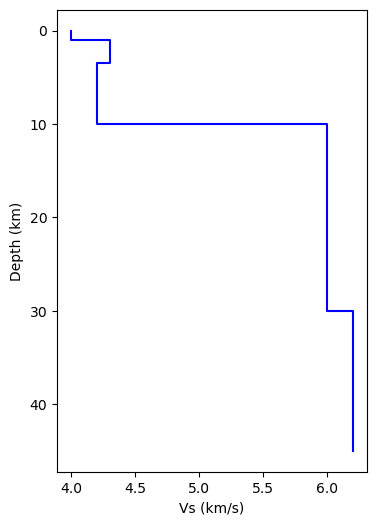

In [5]:
my_receiver_function.plot_model(null_model);

Now we calculate the receiver function and plot it

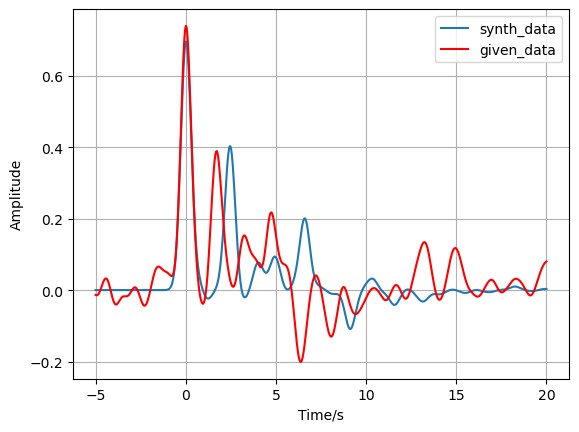

In [6]:
synth_data = my_receiver_function.forward(null_model)
given_data = my_receiver_function.data
my_receiver_function.plot_data(
    data=synth_data, 
    data2=given_data, 
    label="synth_data", 
    label2="given_data"
)
plt.legend();

## 1. Define the problem

In [7]:
my_problem = cofi.BaseProblem()

In [8]:
def my_log_likelihood(model):
    synth_data = my_receiver_function.forward(model)
    result = my_receiver_function.log_likelihood(synth_data, given_data)
    if math.isnan(result):
        return -np.inf
    return result

my_problem.set_log_likelihood(my_log_likelihood)
my_problem.set_log_prior(my_receiver_function.log_prior)

In [9]:
ndim = my_receiver_function.model_size
my_problem.set_model_shape(ndim)

Review what information is included in the `BaseProblem` object:

In [10]:
my_problem.summary()

Summary for inversion problem: BaseProblem
Model shape: 2
---------------------------------------------------------------------
List of functions/properties set by you:
['log_likelihood', 'log_prior', 'model_shape', 'blobs_dtype']
---------------------------------------------------------------------
List of functions/properties created based on what you have provided:
['log_posterior', 'log_posterior_with_blobs']
---------------------------------------------------------------------
List of functions/properties that can be further set for the problem:
( not all of these may be relevant to your inversion workflow )
['objective', 'log_posterior', 'log_posterior_with_blobs', 'gradient', 'hessian', 'hessian_times_vector', 'residual', 'jacobian', 'jacobian_times_vector', 'data_misfit', 'regularization', 'regularization_matrix', 'regularization_factor', 'forward', 'data', 'data_covariance', 'data_covariance_inv', 'initial_model', 'bounds', 'constraints']


## 2. Define the inversion options

In [11]:
my_options = cofi.InversionOptions()
my_options.set_tool("emcee")

In [12]:
nwalkers = 8
nsteps = 500
walkers_start = null_model + 1e-1 * np.random.randn(nwalkers, ndim)

In [13]:
my_options.set_params(
    nwalkers=nwalkers, 
    nsteps=nsteps, 
    initial_state=walkers_start,
    progress=True,
)

Review what's been defined for the inversion we are about to run:

In [14]:
my_options.summary()

Summary for inversion options
Solving method: None set
Use `suggest_solving_methods()` to check available solving methods.
-----------------------------
Backend tool: `<class 'cofi.tools._emcee.Emcee'>` - an MIT licensed pure-Python implementation of Goodman & Weare’s Affine Invariant Markov chain Monte Carlo (MCMC) Ensemble sampler
References: ['https://emcee.readthedocs.io/en/stable/user/sampler/#emcee.EnsembleSampler', 'https://emcee.readthedocs.io/en/stable/user/sampler/#emcee.EnsembleSampler.sample']
Use `suggest_tools()` to check available backend tools.
-----------------------------
Solver-specific parameters: 
nwalkers = 8
nsteps = 500
initial_state = [[10.03929897 30.17897751]
 [10.17932071 30.05916361]
 [10.05470789 29.91769208]
 [10.00856462 30.07095745]
 [10.12077653 29.90646893]
 [ 9.92661667 29.81379709]
 [ 9.89702347 30.04995963]
 [10.06915332 30.04013029]]
progress = True
Use `suggest_solver_params()` to check required/optional solver-specific parameters.


## 3. Start an inversion

In [15]:
inv = cofi.Inversion(my_problem, my_options)
inv_result = inv.run()
inv_result.summary()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [40:43<00:00,  4.89s/it]

Summary for inversion result
SUCCESS
----------------------------
sampler: <emcee.ensemble.EnsembleSampler object>
blob_names: ['log_likelihood', 'log_prior']


## 4. Plotting

In [16]:
az_inf_data = inv_result.to_arviz()
az_inf_data

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> prior

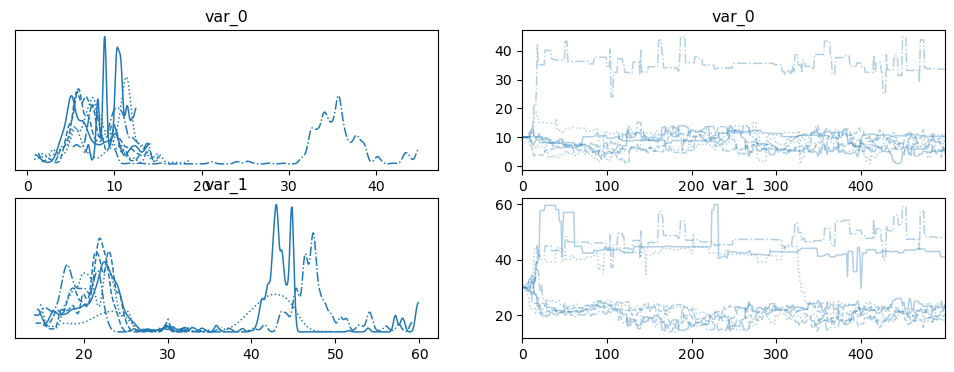

In [17]:
arviz.plot_trace(az_inf_data);

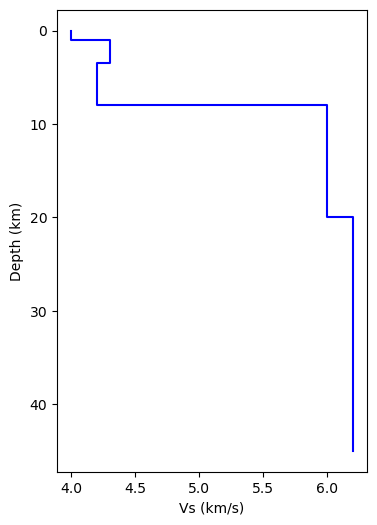

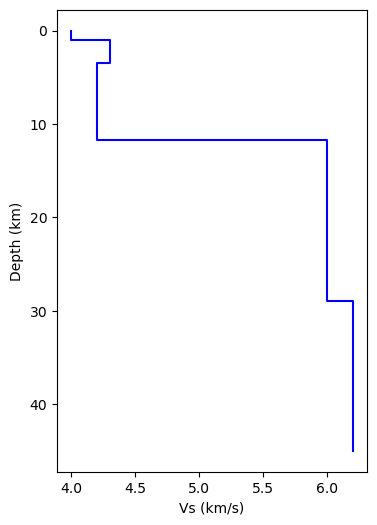

In [18]:
true_model = my_receiver_function.good_model
mean_sample = np.array(az_inf_data["posterior"].mean().to_array())

my_receiver_function.plot_model(true_model);
my_receiver_function.plot_model(mean_sample);

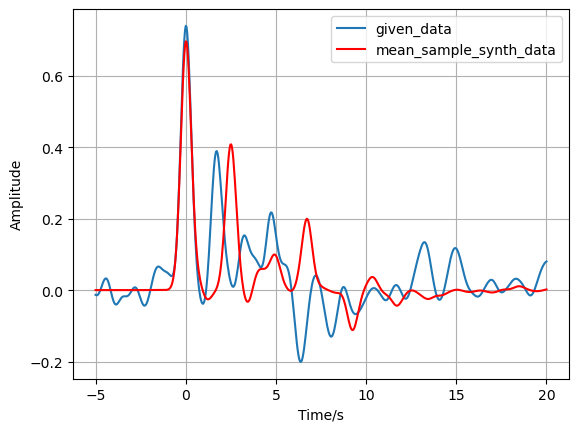

In [19]:
mean_sample_synth_data = my_receiver_function.forward(mean_sample)
my_receiver_function.plot_data(
    given_data, 
    mean_sample_synth_data,
    "given_data",
    "mean_sample_synth_data",
);
plt.legend();

---
## Watermark

<!-- Feel free to add more modules in the watermark_list below, if more packages are used -->
<!-- Otherwise please leave the below code cell unchanged -->

In [20]:
watermark_list = ["cofi", "espresso", "numpy", "matplotlib", "emcee", "arviz"]
for pkg in watermark_list:
    pkg_var = __import__(pkg)
    print(pkg, getattr(pkg_var, "__version__"))

cofi 0.1.3.dev2
espresso 0.3.1
numpy 1.23.5
matplotlib 3.5.1
emcee 3.1.4
arviz 0.15.1
